## Calibración 

In [ ]:
from xgboost import XGBRegressor
from mapie.regression import MapieRegressor

# 1. Hiperparámetros óptimos
best_params = {
    'n_estimators': 500,
    'min_child_weight': 20,
    'max_depth': 3,
    'learning_rate': 0.005
}

# 2. Modelo base (solo uno: MAPIE genera los intervalos)
xgb_model = XGBRegressor(
    **best_params,
    random_state=23,
    n_jobs=-1
)

xgb_model.fit(X_train_processed, y_train)

# Usamos el modelo XGBoost original (xgb_model)
mapie_conformal = MapieRegressor(
    estimator=xgb_model, # Tu modelo XGBoost ajustado
    method="plus", # Un método robusto para regresión
    cv="prefit", # Indicamos que el modelo ya está entrenado
)


In [ ]:
# El ajuste se hace solo para calcular el score de no-conformidad
# 4. Ajuste con el set de calibración
mapie_conformal.fit(X_cal_processed, y_calibration)  # X_cal es tu set de calibración

# 5. Predicciones con intervalos
alpha = 0.05
y_pred, y_intervals = mapie_conformal.predict(X_test_processed, alpha=alpha)

lower = y_intervals[:, 0]
upper = y_intervals[:, 1]

print("Predicción:", y_pred[:5])
print("Límite inferior:", lower[:5])
print("Límite superior:", upper[:5])

Predicción: [2.4148111 2.4929087 2.4978125 2.4335046 2.5758786]
Límite inferior: [[0.9585288 ]
 [1.03662639]
 [1.04153018]
 [0.97722225]
 [1.11959629]]
Límite superior: [[3.87109346]
 [3.94919105]
 [3.95409484]
 [3.88978691]
 [4.03216095]]


In [ ]:
import numpy as np

def evaluate_intervals(y_true, lower, upper, alpha):
    """Calcula la cobertura empírica y el ancho promedio de los intervalos."""
    
    # Cobertura: ¿El valor real (y_true) está entre el límite inferior y superior?
    coverage = np.mean((y_true.values >= lower) & (y_true.values <= upper))
    
    # Ancho Promedio: La diferencia promedio entre el límite superior e inferior
    width = np.mean(upper - lower)
    
    print("--- Evaluación de Intervalos de Predicción ---")
    print(f"Intervalo objetivo (1-alpha): {1 - alpha:.2f} (95%)")
    print(f"Cobertura empírica (real): {coverage:.4f}")
    print(f"Ancho promedio del intervalo: {width:.4f}")
    
# Llama a la función con tus resultados:
# evaluate_intervals(y_test, lower, upper, alpha)

In [ ]:
evaluate_intervals(y_test, lower, upper, alpha)

--- Evaluación de Intervalos de Predicción ---
Intervalo objetivo (1-alpha): 0.95 (95%)
Cobertura empírica (real): 1.0000
Ancho promedio del intervalo: 2.9126


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D # Para la leyenda personalizada

# Asume que y_test es una Serie de Pandas
def plot_interval_evaluation(y_true, y_pred, lower, upper, sample_size=50):
    
    # 1. Tomar una muestra aleatoria para un gráfico claro
    n_points = len(y_true)
    idx = np.random.choice(n_points, size=sample_size, replace=False)

    # --- CORRECCIÓN CLAVE: Aseguramos que todas las muestras sean arrays 1D ---
    y_true_sample = y_true.iloc[idx].values.flatten() # Añadido .flatten()
    y_pred_sample = y_pred[idx].flatten() # Añadido .flatten()
    lower_sample = lower[idx].flatten() # Añadido .flatten()
    upper_sample = upper[idx].flatten() # Añadido .flatten()

    # Esta línea ahora tendrá la forma correcta (2, 20)
    error = [y_pred_sample - lower_sample, upper_sample - y_pred_sample]
    plt.errorbar(range(sample_size), y_pred_sample, yerr=error, fmt='o', 
                 color='skyblue', alpha=0.6, capsize=4, markersize=5,
                 label='Intervalo de Predicción (Límite Superior/Inferior)')
    
    # 3. Plotear los valores verdaderos (y_true)
    plt.scatter(range(sample_size), y_true_sample, color='red', s=40, zorder=3, 
                label='Valor Real ($y_{true}$)')
    
    # 4. Plotear las predicciones puntuales
    plt.scatter(range(sample_size), y_pred_sample, color='blue', s=20, zorder=3,
                label='Predicción Puntual')

    # Leyenda personalizada para indicar la cobertura
    custom_lines = [
        Line2D([0], [0], color='red', marker='o', linestyle='None'),
        Line2D([0], [0], color='skyblue', alpha=0.6),
        Line2D([0], [0], color='blue', marker='o', linestyle='None')
    ]
    plt.legend(custom_lines, ['Valor Real ($y_{true}$)', 'Intervalo de Predicción', 'Predicción Puntual'], 
               loc='upper right')

    plt.title(f'Visualización de Intervalos de Predicción (Cobertura: 100%)')
    plt.xlabel(f'Punto de Datos Muestreado ({sample_size} puntos)')
    plt.ylabel('Valor de Riesgo')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()



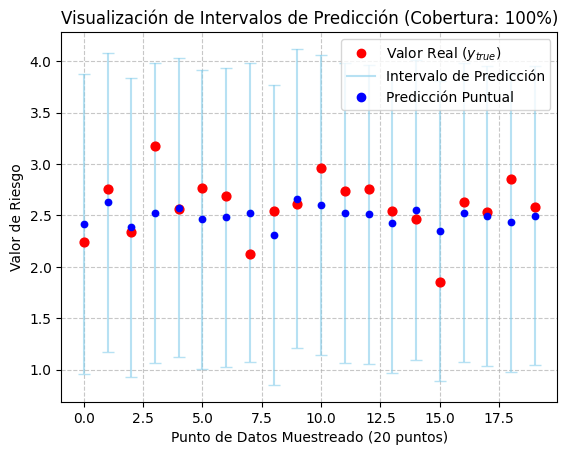

In [ ]:
# Llama a la función con tus datos:
plot_interval_evaluation(y_test, y_pred, lower, upper, sample_size=20)